# Reading data

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('activation.txt', sep=':')

In [3]:
data.shape

(9108, 3)

In [4]:
data = data.dropna().reset_index(drop=True)

In [5]:
data.shape

(9108, 3)

In [6]:
data.head(2)

,filename,num,text
0,10014.txt,1,да виктория мне надо зарегистрировать новую ка...
1,10020.txt,1,я за активировала карту а нет и не известные н...


# Reading MasterCard data

In [2]:
import pandas as pd

In [3]:
data = pd.read_pickle("new_data.pkl")
data = data.rename(columns={"message": "text"})
data.head()

,sp_id,local_datetime,text,lemma
5,2,2018-04-06T00:12:29+0300,giving you money back. thanks,"[giving, you, money, back, thanks]"
6,2,2018-04-06T00:14:18+0300,giving you money back. thanks,"[giving, you, money, back, thanks]"
7,2,2018-04-06T00:22:56+0300,for Ivan's birthday,"[for, ivan, birthday]"
8,2,2018-04-06T00:24:03+0300,for Ivan's birthday,"[for, ivan, birthday]"
9,2,2018-04-06T14:09:20+0300,for Ivan's birthday,"[for, ivan, birthday]"


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33183 entries, 5 to 684612
Data columns (total 4 columns):
sp_id             33183 non-null int64
local_datetime    33183 non-null object
text              33183 non-null object
lemma             33183 non-null object
dtypes: int64(1), object(3)
memory usage: 1.3+ MB


In [7]:
data.query("text == text").shape

(33183, 4)

# Cleaning

#### Keeping English articles

In [5]:
from langdetect import detect
from tqdm import tqdm_notebook
tqdm_notebook().pandas()

/anaconda3/lib/python3.7/site-packages/tqdm/_tqdm.py:603: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [6]:
data['lang'] = data.text.progress_map(detect)

LangDetectException: No features in text.

In [11]:
data.lang.value_counts()

ru    9107
bg       1
Name: lang, dtype: int64

In [12]:
data = data.loc[data.lang=='ru']

#### Tokenization

In [8]:
data.head()

,sp_id,local_datetime,text,lemma
5,2,2018-04-06T00:12:29+0300,giving you money back. thanks,"[giving, you, money, back, thanks]"
6,2,2018-04-06T00:14:18+0300,giving you money back. thanks,"[giving, you, money, back, thanks]"
7,2,2018-04-06T00:22:56+0300,for Ivan's birthday,"[for, ivan, birthday]"
8,2,2018-04-06T00:24:03+0300,for Ivan's birthday,"[for, ivan, birthday]"
9,2,2018-04-06T14:09:20+0300,for Ivan's birthday,"[for, ivan, birthday]"


In [13]:
data = data.reset_index()
data.head(2)

,index,sp_id,local_datetime,text,lemma,sentences
0,5,2,2018-04-06T00:12:29+0300,giving you money back. thanks,"[giving, you, money, back, thanks]","[giving you money back., thanks]"
1,6,2,2018-04-06T00:14:18+0300,giving you money back. thanks,"[giving, you, money, back, thanks]","[giving you money back., thanks]"


In [14]:
from nltk.tokenize import sent_tokenize

In [15]:
data['sentences'] = data.text.progress_map(sent_tokenize)
data['sentences'].head(1).tolist()[0][:3] # Print the first 3 sentences of the 1st article

['giving you money back.', 'thanks']

In [16]:
data['sentences'].head(1)

0    [giving you money back., thanks]
Name: sentences, dtype: object

In [17]:
data['sentences'].head(1)[0]

['giving you money back.', 'thanks']

In [18]:
type(data['sentences'].head(1)[0])

list

In [19]:
data['sentences'].head(1).tolist()

[['giving you money back.', 'thanks']]

In [20]:
from nltk.tokenize import word_tokenize

In [21]:
data['tokens_sentences'] = data['sentences'].progress_map(lambda sentences: [word_tokenize(sentence) for sentence in sentences])
print(data['tokens_sentences'].head(1).tolist()[0][:3])

[['giving', 'you', 'money', 'back', '.'], ['thanks']]


#### Lemmatizing with POS tagging

In [22]:
from nltk import pos_tag

In [23]:
import nltk
nltk.download('averaged_perceptron_tagger_ru')

[nltk_data] Downloading package averaged_perceptron_tagger_ru to
[nltk_data]     /Users/sergeyzakharov/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_ru is already up-to-
[nltk_data]       date!


True

In [24]:
#morph.parse('шестнадцать')[0].tag._POS
#data['POS_tokens'] = data['tokens_sentences'].progress_map(lambda tokens_sentences: [(token, morph.parse(token)[0].tag._POS) for token in tokens for tokens in tokens_sentences])
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

def get_proper_tag( token ):

    p = morph.parse(token)[0]
    tag  = p.tag._POS
    
    if ( 'Name' in p.tag):
        return "PERSON"
    else:
        return tag

data['POS_tokens'] = data['tokens_sentences'].progress_map(lambda tokens_sentences: [[ ( tok, get_proper_tag(tok)) for tok in tokens]   for tokens in tokens_sentences  ])
print(data['POS_tokens'].head(1).tolist()[0][:3])

[[('giving', 'LATN'), ('you', 'LATN'), ('money', 'LATN'), ('back', 'LATN'), ('.', 'PNCT')], [('thanks', 'LATN')]]


In [25]:
# Inspired from https://stackoverflow.com/a/15590384
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag, token, full):

    #if ( token == 'семьсот'):
    #    print("Horror {} and its tag={}".format(full, treebank_tag))
    if treebank_tag.startswith('VERB'):
        return wordnet.VERB
    elif treebank_tag.startswith('NOUN'):
        return wordnet.NOUN
    elif treebank_tag.startswith('INFN'):
        return wordnet.VERB
    #elif treebank_tag.startswith('R'):
    #    return wordnet.ADV
    else:
        return ''

from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [26]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sergeyzakharov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [27]:
data.head(2)

,index,sp_id,local_datetime,text,lemma,sentences,tokens_sentences,POS_tokens
0,5,2,2018-04-06T00:12:29+0300,giving you money back. thanks,"[giving, you, money, back, thanks]","[giving you money back., thanks]","[[giving, you, money, back, .], [thanks]]","[[(giving, LATN), (you, LATN), (money, LATN), ..."
1,6,2,2018-04-06T00:14:18+0300,giving you money back. thanks,"[giving, you, money, back, thanks]","[giving you money back., thanks]","[[giving, you, money, back, .], [thanks]]","[[(giving, LATN), (you, LATN), (money, LATN), ..."


In [28]:

# Lemmatizing each word with its POS tag, in each sentence
#data['POS_tokens'] = data['POS_tokens'].progress_filter( lambda list_tokens_POS : filte)
data['tokens_sentences_lemmatized'] = data['POS_tokens'].progress_map(
    lambda list_tokens_POS:  [
        [
            morph.parse(el[0])[0].normal_form
            for el in tokens_POS if get_wordnet_pos( el[1], el[0], tokens_POS) != ''
        ] 
        for tokens_POS in list_tokens_POS
    ]
)

In [29]:
data['tokens_sentences_lemmatized'].head(10).tolist()[:10][:3]

#list(filter( lambda x: x != None, data['tokens_sentences_lemmatized'].head(1).tolist()[0][0]))

[[[], []], [[], []], [[]]]

#### Regrouping tokens and removing stop words

In [30]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sergeyzakharov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
from nltk.corpus import stopwords
stopwords_other = ['тысяча','минутка','секунда','минуточка','секундочка','цифра','алло','телефон','номер','ноль','девушка', 'свидание','хотеть', 'всё','просто','спасибо','верно','ага','здравствовать','мочь','без', 'более', 'бы', 'быть', 'вам', 'вас', 'ведь', 'весь', 'вдоль', 'вместо', 'вне', 'вниз', 'внизу', 'внутри', 'во', 'вокруг', 'вот', 'все', 'всегда', 'всего', 'всех', 'вы', 'где', 'да', 'давай', 'давать', 'даже', 'для', 'до', 'достаточно', 'его', 'ее', 'её', 'если', 'есть', 'ещё', 'же', 'за', 'исключением', 'здесь', 'из', 'из-за', 'или', 'им', 'иметь', 'их', 'как', 'как-то', 'кто', 'когда', 'кроме', 'кто', 'ли', 'либо', 'мне', 'может', 'мои', 'мой', 'мы', 'на', 'навсегда', 'над', 'надо', 'наш', 'не', 'него', 'неё', 'нет', 'ни', 'них', 'но', 'ну', 'об', 'однако', 'он', 'она', 'они', 'оно', 'от', 'отчего', 'очень', 'по', 'под', 'после', 'потому', 'что', 'почти', 'при', 'про', 'снова', 'со', 'так', 'также', 'такие', 'такой', 'там', 'те', 'тем', 'то', 'того', 'тоже', 'той', 'только', 'том', 'тут', 'ты', 'уже', 'хотя', 'чего', 'чего-то', 'чей', 'чем', 'что', 'чтобы', 'чьё', 'чья', 'эта', 'эти', 'это']
my_stopwords = stopwords.words('russian') +  stopwords_other

In [32]:
from itertools import chain # to flatten list of sentences of tokens into list of tokens

In [33]:
data['tokens'] = data['tokens_sentences_lemmatized'].map(lambda sentences: list(chain.from_iterable(sentences)))
data['tokens'] = data['tokens'].map(lambda tokens: [token.lower() for token in tokens if token.isalpha() 
                                                    and token.lower() not in my_stopwords and len(token)>1])

In [34]:
data['tokens'].head(10).tolist()[:10][:30]

[[], [], [], [], [], [], [], [], [], []]

# LDA

## Data preparation

#### Prepare bi-grams and tri-grams

In [35]:
from gensim.models import Phrases

In [36]:
tokens = data['tokens'].tolist()
bigram_model = Phrases(tokens)
trigram_model = Phrases(bigram_model[tokens], min_count=1)
tokens = list(trigram_model[bigram_model[tokens]])

#### Prepare objects for LDA gensim implementation

In [37]:
from gensim import corpora

In [38]:
dictionary_LDA = corpora.Dictionary(tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(tok) for tok in tokens]

## Running LDA

In [44]:
from gensim import models
import numpy as np

In [55]:
np.random.seed(123456)
num_topics = 7
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=3, alpha=[0.08]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

CPU times: user 8.54 s, sys: 14.2 ms, total: 8.55 s
Wall time: 8.55 s


## Quick exploration of LDA results

#### Looking at topics

In [56]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    print(str(i)+": "+ topic)
    print()

0: 0.188*"долг" + 0.158*"перевод" + 0.133*"оплата" + 0.096*"проверка" + 0.046*"проба" + 0.045*"др" + 0.032*"рубль" + 0.027*"александр" + 0.026*"прислать" + 0.020*"владимир" + 0.020*"торт" + 0.019*"стрижка" + 0.018*"ир" + 0.018*"написать" + 0.015*"душа" + 0.014*"перевод_средство" + 0.012*"юбилей" + 0.009*"взять" + 0.008*"варение" + 0.008*"дух"

1: 0.579*"привет" + 0.058*"обед" + 0.038*"карта" + 0.030*"возврат_долг" + 0.026*"пиво" + 0.023*"целовать" + 0.022*"свет" + 0.019*"пополнение_счёт" + 0.017*"вика" + 0.015*"пицца" + 0.014*"день" + 0.011*"плата" + 0.011*"отказывать" + 0.008*"человек" + 0.008*"сергеев" + 0.007*"ночь" + 0.007*"выздоравливать" + 0.006*"морожёнка" + 0.006*"процент" + 0.005*"март"

2: 0.118*"перевести" + 0.085*"сентябрь" + 0.084*"хуй" + 0.050*"аванс" + 0.045*"должок" + 0.036*"брат" + 0.035*"сын" + 0.035*"гараж" + 0.034*"жена" + 0.031*"поздравлять" + 0.030*"ребёнок" + 0.029*"виктор" + 0.029*"праздник" + 0.029*"страховка" + 0.019*"вернуть" + 0.017*"благодарить" + 0.016*"са

#### Allocating topics to documents

In [57]:
#print(data.articles.loc[0][:500])

In [58]:
lda_model[corpus[0]]

[(0, 0.14285713),
 (1, 0.14285713),
 (2, 0.14285713),
 (3, 0.14285713),
 (4, 0.14285713),
 (5, 0.14285713),
 (6, 0.14285713)]

#### Predicting topics on unseen documents

In [59]:
document = '''Eric Tucker, a 35-year-old co-founder of a marketing company in Austin, Tex., had just about 40 Twitter followers. But his recent tweet about paid protesters being bused to demonstrations against President-elect Donald J. Trump fueled a nationwide conspiracy theory — one that Mr. Trump joined in promoting. 

Mr. Tucker's post was shared at least 16,000 times on Twitter and more than 350,000 times on Facebook. The problem is that Mr. Tucker got it wrong. There were no such buses packed with paid protesters.

But that didn't matter.

While some fake news is produced purposefully by teenagers in the Balkans or entrepreneurs in the United States seeking to make money from advertising, false information can also arise from misinformed social media posts by regular people that are seized on and spread through a hyperpartisan blogosphere.

Here, The New York Times deconstructs how Mr. Tucker’s now-deleted declaration on Twitter the night after the election turned into a fake-news phenomenon. It is an example of how, in an ever-connected world where speed often takes precedence over truth, an observation by a private citizen can quickly become a talking point, even as it is being proved false.'''
tokens = word_tokenize(document)
topics = lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20)
pd.DataFrame([(el[0], round(el[1],2), topics[el[0]][1]) for el in lda_model[dictionary_LDA.doc2bow(tokens)]], columns=['topic #', 'weight', 'words in topic'])

,topic #,weight,words in topic
0,0,0.14,"0.188*""долг"" + 0.158*""перевод"" + 0.133*""оплата..."
1,1,0.14,"0.579*""привет"" + 0.058*""обед"" + 0.038*""карта"" ..."
2,2,0.14,"0.118*""перевести"" + 0.085*""сентябрь"" + 0.084*""..."
3,3,0.14,"0.290*""любить"" + 0.088*""тест"" + 0.055*""максим""..."
4,4,0.14,"0.111*""такси"" + 0.103*""деньга"" + 0.088*""получи..."
5,5,0.14,"0.293*""рождение"" + 0.107*""мама"" + 0.083*""подар..."
6,6,0.14,"0.215*""ловить"" + 0.083*""кредит"" + 0.078*""держа..."


## Advanced exploration of LDA results

In [72]:
pyLDAvis.save_html(vis, 'lda.html')

In [61]:
# https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf
# Here a short legend to explain the vis:
# size of bubble: proportional to the proportions of the topics across the N total tokens in the corpus
# red bars: estimated number of times a given term was generated by a given topic
# blue bars: overall frequency of each term in the corpus
# -- Relevance of words is computed with a parameter lambda
# -- Lambda optimal value ~0.6 (https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf)
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


#### Allocation of topics in all documents

In [62]:
topics = [lda_model[corpus[i]] for i in range(len(data))]

In [63]:
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

topics_document_to_dataframe([(9, 0.03853655432967504), (15, 0.09130117862212643), (18, 0.8692868808484044)], 20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0385366,NaN,NaN,NaN,NaN,NaN,0.0913012,NaN,NaN,0.869287,NaN


In [64]:
# Like TF-IDF, create a matrix of topic weighting, with documents as rows and topics as columns
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

In [65]:
document_topic.head()

,0,1,2,3,4,5,6
0,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
1,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
2,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
3,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
4,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857


In [67]:
# Which document are about topic 14
document_topic.sort_values(6, ascending=False)[6].head(20)

1818     0.865167
2142     0.865166
4508     0.812500
7380     0.812500
4511     0.812500
8553     0.812499
20955    0.812499
9435     0.812499
1238     0.812499
25022    0.812499
4929     0.812498
1622     0.812498
14181    0.812497
1868     0.812497
1556     0.812496
25113    0.812493
819      0.812493
104      0.812490
711      0.812490
1250     0.812472
Name: 6, dtype: float64

In [68]:
data.head(2)

,index,sp_id,local_datetime,text,lemma,sentences,tokens_sentences,POS_tokens,tokens_sentences_lemmatized,tokens
0,5,2,2018-04-06T00:12:29+0300,giving you money back. thanks,"[giving, you, money, back, thanks]","[giving you money back., thanks]","[[giving, you, money, back, .], [thanks]]","[[(giving, LATN), (you, LATN), (money, LATN), ...","[[], []]",[]
1,6,2,2018-04-06T00:14:18+0300,giving you money back. thanks,"[giving, you, money, back, thanks]","[giving you money back., thanks]","[[giving, you, money, back, .], [thanks]]","[[(giving, LATN), (you, LATN), (money, LATN), ...","[[], []]",[]


In [69]:
print(data.text.loc[4543][:1000])

 для собаки


#### Looking at the distribution of topics in all documents

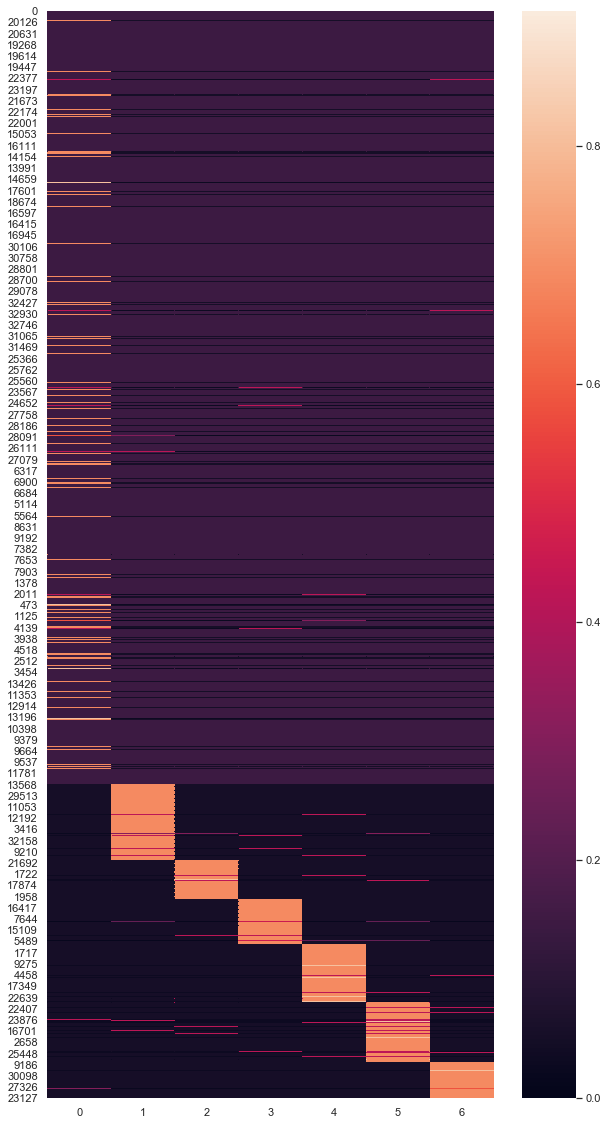

In [70]:
%matplotlib inline
import seaborn as sns; sns.set(rc={'figure.figsize':(10,20)})
sns.heatmap(document_topic.loc[document_topic.idxmax(axis=1).sort_values().index])

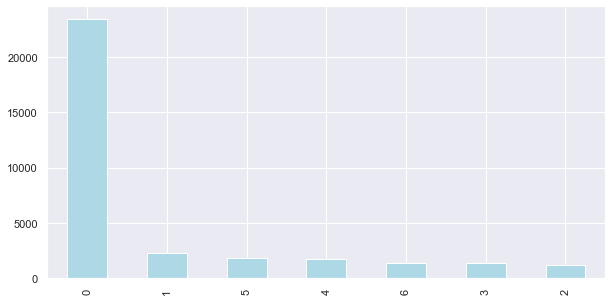

In [71]:
sns.set(rc={'figure.figsize':(10,5)})
document_topic.idxmax(axis=1).value_counts().plot.bar(color='lightblue')

#### Visualizing topics